<a href="https://colab.research.google.com/github/maciejskorski/NonobliviousRademacherProjections/blob/main/notebooks/OptimalRademacherEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn import random_projection

def calculate_sparsity(A):
    sparsity = 1 - np.count_nonzero(A)/np.prod(A.shape)
    return sparsity

In [2]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
import seaborn as sns

X = np.random.rand(1,100)
X /= np.linalg.norm(X,ord=2,axis=1,keepdims=True)

X.shape

(1, 100)

# Data sparsity vs distortion

Suppose that we project a vector with $L$ non-zero components, from $n_{input}$ to $n_{embed}$ dimensions with an appropriate matrix $P$.

* How does the distortion $\|P x\|^2 / \|x\|^2$ depend on $L$?
* How does the distortion depend on the embeddibg sparsity $p$?

On synthetic data, we will see that the embedding performance improves with higher sparsity (smaller $L$) and higher projection density (umtilately, Rademacher projections are best, if can be be computationally afforded).

<Axes: xlabel='distortion', ylabel='Density'>

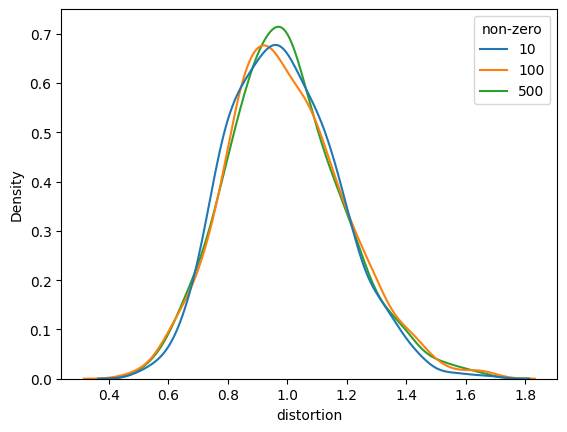

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 500 # length of projection input
N_EMBED = 50 # length of projection output
L = [10,100,500] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []
for l in L:
  # build vectors with L non-zero components out of N_INPUT
  X = np.zeros((N_INPUT,))
  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)
  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0) # reshape to (1,N)


  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=1.0)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    #outs.append((distortion))
    outs.append((distortion,l))

df = pd.DataFrame(outs, columns=["distortion", "non-zero"])

#sns.kdeplot(outs, legend=True)
sns.kdeplot(data=df, x="distortion", hue="non-zero", palette="tab10")

<Axes: xlabel='distortion', ylabel='Density'>

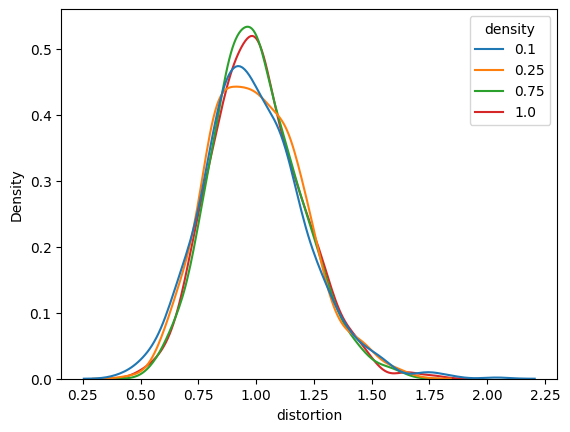

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 5000 # length of projection input
N_EMBED = 50 # length of projection output
L = 10 # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []

# build vectors with L non-zero components out of N_INPUT
X = np.zeros((N_INPUT,))
idxs = np.random.choice(range(N_INPUT),size=(L,),replace=False)
X[idxs] = 1
X = X/np.linalg.norm(X,2) # normalize input
X = np.expand_dims(X,0)

for dens in [0.1,0.25,0.75,1.0]:
  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    #outs.append((distortion))
    outs.append((distortion,dens))

df = pd.DataFrame(outs, columns=["distortion", "density"])

#sns.kdeplot(outs, legend=True)
sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")

<Axes: xlabel='distortion', ylabel='Density'>

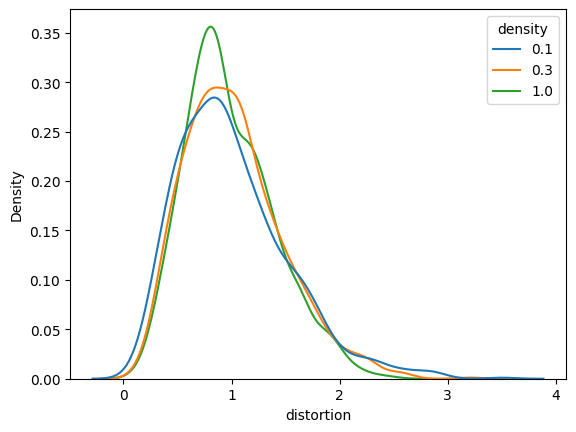

In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 10000 # length of projection input
N_EMBED = 10 # length of projection output
L = 10 # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []

# build vectors with L non-zero components out of N_INPUT
X = np.zeros((N_INPUT,))
idxs = np.random.choice(range(N_INPUT),size=(L,),replace=False)
X[idxs] = 1
X = X/np.linalg.norm(X,2) # normalize input
X = np.expand_dims(X,0)

for dens in [0.1,0.30,1.0]:
  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    outs.append((distortion,dens))

df = pd.DataFrame(outs, columns=["distortion", "density"])

sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")

In [6]:
df.groupby('density').agg(['mean','std'])

distortion          
              mean       std
density                     
0.1       1.006500  0.511027
0.3       1.020333  0.455471
1.0       0.984800  0.409207

# Performance on real world datasets

##Download datasets

In [7]:
datasets = {}

### MNIST

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.random_projection import SparseRandomProjection

mnist = tf.keras.datasets.mnist
(train_inputs, train_labels), _ = mnist.load_data()
train_inputs = train_inputs / 255.0

n_samples = 50
#n_samples = 500

subsample = np.random.random_integers(0,train_inputs.shape[0],size=n_samples)

Xs = train_inputs[subsample]

datasets['MNIST'] = Xs

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-8-ec7da560b748>:15: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  subsample = np.random.random_integers(0,train_inputs.shape[0],size=n_samples)


### CIFAR10

In [9]:
from tensorflow.keras.datasets import cifar10

n_samples = 50
#n_samples = 100

(train_data,_),_ = cifar10.load_data()
subsample = np.random.random_integers(0,len(train_data),n_samples)
#cifar10 = train_data[subsample][:,:,:,0]
Xs = train_data[subsample][:,:,:,0]
#datasets = {'CIFAR10': Xs}
datasets['CIFAR10'] = Xs
#average_param_gain(Xs)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<ipython-input-9-e67bc380cb8b>:7: DeprecationWarning: This function is deprecated. Please call randint(0, 50000 + 1) instead
  subsample = np.random.random_integers(0,len(train_data),n_samples)


### NIPS

In [10]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv

import pandas as pd

n_samples = 50
#n_samples = 200

# beware that features are in rows (words)
d = pd.read_csv('NIPS_1987-2015.csv')

subsample = np.random.random_integers(0,d.shape[1],size=n_samples)
cols = d.columns[subsample]
Xs = d[cols].T
Xs = Xs.to_numpy()
Xs = [x for x in Xs]

datasets['NIPS'] = Xs

--2024-08-25 16:09:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NIPS_1987-2015.csv’

NIPS_1987-2015.csv      [               <=>  ] 127.40M  44.3MB/s    in 2.9s    

2024-08-25 16:09:03 (44.3 MB/s) - ‘NIPS_1987-2015.csv’ saved [133587258]



<ipython-input-10-fcacee4d0131>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 5812 + 1) instead
  subsample = np.random.random_integers(0,d.shape[1],size=n_samples)


### Mycielski

In [11]:
import scipy.io

!wget https://suitesparse-collection-website.herokuapp.com/MM/Mycielski/mycielskian17.tar.gz
!tar -xf mycielskian17.tar.gz

n_samples = 50

file_name = 'mycielskian17/mycielskian17.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]
datasets['Mycielski'] = Xs

--2024-08-25 16:09:12--  https://suitesparse-collection-website.herokuapp.com/MM/Mycielski/mycielskian17.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.224.34.30, 34.201.81.34, 54.208.186.182, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.224.34.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/Mycielski/mycielskian17.tar.gz [following]
--2024-08-25 16:09:12--  http://sparse-files.engr.tamu.edu/MM/Mycielski/mycielskian17.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.104.187, 52.219.108.80, 52.219.110.176, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.104.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120811979 (115M) [application/x-tar]
Saving to: ‘mycielskian17.tar.gz’

my

<ipython-input-11-e4b79abd4b04>:12: DeprecationWarning: This function is deprecated. Please call randint(0, 98303 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### Goodwin

In [12]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/Goodwin/Goodwin_040.tar.gz
!tar -xf Goodwin_040.tar.gz

n_samples = 50

file_name = 'Goodwin_040/Goodwin_040.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['Goodwin'] = Xs

--2024-08-25 16:09:34--  https://suitesparse-collection-website.herokuapp.com/MM/Goodwin/Goodwin_040.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/Goodwin/Goodwin_040.tar.gz [following]
--2024-08-25 16:09:34--  http://sparse-files.engr.tamu.edu/MM/Goodwin/Goodwin_040.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882792 (2.7M) [application/x-tar]
Saving to: ‘Goodwin_040.tar.gz’

Goodwin_040.tar.gz  10

<ipython-input-12-dd8e235f3ddd>:10: DeprecationWarning: This function is deprecated. Please call randint(0, 17922 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### 1138_bus

In [13]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/HB/1138_bus.tar.gz
!tar -xf 1138_bus.tar.gz

#n_samples = 50
n_samples = 100

file_name = '1138_bus/1138_bus.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['1138_bus'] = Xs
#Power Network Problem

--2024-08-25 16:09:34--  https://suitesparse-collection-website.herokuapp.com/MM/HB/1138_bus.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/HB/1138_bus.tar.gz [following]
--2024-08-25 16:09:35--  http://sparse-files.engr.tamu.edu/MM/HB/1138_bus.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19829 (19K) [application/x-tar]
Saving to: ‘1138_bus.tar.gz’

1138_bus.tar.gz     100%[===================>]  19.3

<ipython-input-13-c1f1510c2b28>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1138 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### bcspwr06

In [14]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/HB/bcspwr06.tar.gz
!tar -xf bcspwr06.tar.gz

n_samples = 50
#n_samples = 100

file_name = 'bcspwr06/bcspwr06.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['bcspwr06'] = Xs
#Power Network Problem

--2024-08-25 16:09:35--  https://suitesparse-collection-website.herokuapp.com/MM/HB/bcspwr06.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/HB/bcspwr06.tar.gz [following]
--2024-08-25 16:09:35--  http://sparse-files.engr.tamu.edu/MM/HB/bcspwr06.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10254 (10K) [application/x-tar]
Saving to: ‘bcspwr06.tar.gz’

bcspwr06.tar.gz     100%[===================>]  10.0

<ipython-input-14-c8f5a8283f40>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1454 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### mnist_test_norm

In [15]:
import scipy.io
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/mnist_test_norm_10NN.tar.gz
!tar -xf mnist_test_norm_10NN.tar.gz

n_samples = 50
#n_samples = 800

file_name = 'mnist_test_norm_10NN/mnist_test_norm_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.randint(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['mnist_test_norm_10NN'] = Xs
#Undirected Weighted Graph

--2024-08-25 16:09:35--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/mnist_test_norm_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/mnist_test_norm_10NN.tar.gz [following]
--2024-08-25 16:09:35--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/mnist_test_norm_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898856 (878K) [application/x-tar]
Saving to: ‘mnist_test_nor

### optdigit

In [16]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/optdigits_10NN.tar.gz
!tar -xf optdigits_10NN.tar.gz

n_samples = 50
#n_samples = 400

file_name = 'optdigits_10NN/optdigits_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['optdigits_10NN'] = Xs
#Undirected Weighted Graph

--2024-08-25 16:09:36--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/optdigits_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/optdigits_10NN.tar.gz [following]
--2024-08-25 16:09:36--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/optdigits_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478572 (467K) [application/x-tar]
Saving to: ‘optdigits_10NN.tar.gz’

optdigit

<ipython-input-16-38f59f5b188a>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 5620 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### plantsmargin

In [17]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantsmargin_12NN.tar.gz
!tar -xf plantsmargin_12NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'plantsmargin_12NN/plantsmargin_12NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['plantsmargin_12NN'] = Xs
#Undirected Weighted Graph

--2024-08-25 16:09:36--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantsmargin_12NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantsmargin_12NN.tar.gz [following]
--2024-08-25 16:09:37--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantsmargin_12NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151077 (148K) [application/x-tar]
Saving to: ‘plantsmargin_12NN.tar.g

<ipython-input-17-2eebce1555f0>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1600 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### planstexture

In [18]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantstexture_10NN.tar.gz
!tar -xf plantstexture_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'plantstexture_10NN/plantstexture_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['plantstexture_10NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:37--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantstexture_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantstexture_10NN.tar.gz [following]
--2024-08-25 16:09:37--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantstexture_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126369 (123K) [application/x-tar]
Saving to: ‘plantstexture_10NN.t

<ipython-input-18-024e68a316f6>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1599 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### semeion

In [19]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/semeion_10NN.tar.gz
!tar -xf semeion_10NN.tar.gz

n_samples = 50
#n_samples = 600

file_name = 'semeion_10NN/semeion_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['semeion_10NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:37--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/semeion_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/semeion_10NN.tar.gz [following]
--2024-08-25 16:09:38--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/semeion_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85567 (84K) [application/x-tar]
Saving to: ‘semeion_10NN.tar.gz’

semeion_10NN.tar.g

<ipython-input-19-83716c42dbd5>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1593 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### umistfacesnorm

In [20]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/umistfacesnorm_10NN.tar.gz
!tar -xf umistfacesnorm_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'umistfacesnorm_10NN/umistfacesnorm_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['umistfacesnorm_10NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:38--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/umistfacesnorm_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/umistfacesnorm_10NN.tar.gz [following]
--2024-08-25 16:09:38--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/umistfacesnorm_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.143.56, 52.219.228.64, 52.219.94.64, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.143.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41257 (40K) [application/x-tar]
Saving to: ‘umistfacesnorm_10NN

<ipython-input-20-39f2e0a53c08>:11: DeprecationWarning: This function is deprecated. Please call randint(0, 575 + 1) instead
  subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)


### Ecoli

In [21]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Ecoli_10NN.tar.gz
!tar -xf Ecoli_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'Ecoli_10NN/Ecoli_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.randint(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['Ecoli_10NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:38--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Ecoli_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/Ecoli_10NN.tar.gz [following]
--2024-08-25 16:09:39--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/Ecoli_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.229.64, 52.219.142.56, 52.219.104.187, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.229.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27740 (27K) [application/x-tar]
Saving to: ‘Ecoli_10NN.tar.gz’

Ecoli_10NN.tar.gz   100%

### usps_norm_5NN

In [22]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/usps_norm_5NN.tar.gz
!tar -xf usps_norm_5NN.tar.gz

n_samples = 50
#n_samples = 300

file_name = 'usps_norm_5NN/usps_norm_5NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.randint(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['usps_norm_5NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:39--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/usps_norm_5NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/usps_norm_5NN.tar.gz [following]
--2024-08-25 16:09:39--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/usps_norm_5NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.229.64, 52.219.142.56, 52.219.104.187, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.229.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467315 (456K) [application/x-tar]
Saving to: ‘usps_norm_5NN.tar.gz’

usps_norm_

### micromass

In [23]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/micromass_10NN.tar.gz
!tar -xf micromass_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'micromass_10NN/micromass_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.randint(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['micromass_10NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:39--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/micromass_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/micromass_10NN.tar.gz [following]
--2024-08-25 16:09:40--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/micromass_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.229.64, 52.219.142.56, 52.219.104.187, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.229.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57569 (56K) [application/x-tar]
Saving to: ‘micromass_10NN.tar.gz’

micromas

### lp_brandy

In [24]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/LPnetlib/lp_brandy.tar.gz
!tar -xf lp_brandy.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'lp_brandy/lp_brandy.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.randint(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['lp_brandy'] = Xs
#Linear Programming


--2024-08-25 16:09:40--  https://suitesparse-collection-website.herokuapp.com/MM/LPnetlib/lp_brandy.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/LPnetlib/lp_brandy.tar.gz [following]
--2024-08-25 16:09:40--  http://sparse-files.engr.tamu.edu/MM/LPnetlib/lp_brandy.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.229.64, 52.219.142.56, 52.219.104.187, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.229.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10688 (10K) [application/x-tar]
Saving to: ‘lp_brandy.tar.gz’

lp_brandy.tar.gz    100%[===

### Glass_10NN

In [25]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Glass_10NN.tar.gz
!tar -xf Glass_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'Glass_10NN/Glass_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.randint(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['Glass_10NN'] = Xs
#Undirected Weighted Graph


--2024-08-25 16:09:40--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Glass_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/Glass_10NN.tar.gz [following]
--2024-08-25 16:09:40--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/Glass_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.229.64, 52.219.142.56, 52.219.104.187, ...
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.229.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19119 (19K) [application/x-tar]
Saving to: ‘Glass_10NN.tar.gz’

Glass_10NN.tar.gz   100%

## Projections

In this experiment, we evaluate embeddings by the Monte Carlo method. To this end, for each dataset we take a subsample of $50$ data points, collect $N=1000$ traces of random embeddings with dimension $D=50$ and calculate the distortions.

The inspection of the distortion distribution results demonstrate that higher data sparsity leads to the improved performance of random projections.

This is in line with theoretical results, that establish Schur concavity for random projections.



Ecoli_10NN
mnist_test_norm_10NN
Glass_10NN
micromass_10NN
plantstexture_10NN


In [176]:
def calculate_sparsity(A):

  sparsity = np.count_nonzero(A,axis=1).mean()
  return sparsity

In [185]:
from sklearn.preprocessing import scale
from tqdm import tqdm

#L = ['Mycielski','Goodwin'] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
#L = ['Goodwin']
#L = ['bcspwr06']
#L = ['1138_bus', 'Mycielski']
#L = ['Goodwin', 'bcspwr06']
#L = ['optdigits_10NN', 'mnist_test_norm_10NN', 'plantsmargin_12NN', 'plantstexture_10NN','semeion_10NN']

N_SAMPLES = 100 # number of randomized projection restarts
#N_INPUT = 50000 # length of projection input
N_EMBED = 50

data_selected = ['Ecoli_10NN','Glass_10NN','micromass_10NN','plantstexture_10NN','NIPS','MNIST']
outs = []

for l in tqdm(data_selected):
  print(l)
  X = datasets[l]
  X = np.asarray(X)
  nsamples = X.shape[0]
  X = X.reshape((nsamples,-1))
  X = X / np.linalg.norm(X,2,axis=-1,keepdims=True)

  out = []
  for dens in [0.1,0.5,1]:
    for _ in range(N_SAMPLES):
      transformer = SparseRandomProjection(n_components=N_EMBED,density=1.0)
      X_new = transformer.fit_transform(X)
      distortion = np.linalg.norm(X_new,2,axis=1)**2
      spars = calculate_sparsity(X)
      out.append(distortion)

  out = np.stack(out)
  outs.append((l,spars,dens,out))


  0%|          | 0/6 [00:00<?, ?it/s]

Ecoli_10NN


 17%|█▋        | 1/6 [00:02<00:14,  2.82s/it]

Glass_10NN


 33%|███▎      | 2/6 [00:03<00:07,  1.78s/it]

micromass_10NN


 50%|█████     | 3/6 [00:05<00:05,  1.82s/it]

plantstexture_10NN


 67%|██████▋   | 4/6 [00:09<00:04,  2.42s/it]

NIPS


 83%|████████▎ | 5/6 [00:23<00:06,  6.85s/it]

MNIST


100%|██████████| 6/6 [00:24<00:00,  4.13s/it]


,sparsity
dataset,
Ecoli_10NN,13.68
Glass_10NN,13.24
MNIST,148.52
NIPS,676.38
micromass_10NN,17.24
plantstexture_10NN,13.92


### Data Sparsity Summary

In [189]:
df = pd.DataFrame(outs).explode(3).explode(3)
df.columns = ['dataset','sparsity','density', 'distortion']
df['distortion'] = df['distortion']-1
df.groupby('dataset')['sparsity'].mean().reset_index()

,dataset,sparsity
0,Ecoli_10NN,13.68
1,Glass_10NN,13.24
2,MNIST,148.52
3,NIPS,676.38
4,micromass_10NN,17.24
5,plantstexture_10NN,13.92


### Performance Analysis Summary

Distortion probability tails are illustrated in relation to data sparsity through three distinct plots:

1. The first plot demonstrates results for Rademacher projections.
2. The second plot showcases results for sparse projections with varying sparsity parameters.
3. The third plot displays distortion densities using Kernel Density Estimations (KDEs).


Recall that more concentrated distributions correspond to better accuracy of projections. This leads to two key findings:

1. Performance improves with increasing data sparsity. In other words, sparser data yields better results.
2. Denser projections provide superior performance. Specifically, Rademacher projections, being the densest, offer the best results.

These observations highlight the significant impact of both data and projection sparsity on the overall performance of the projection methods.

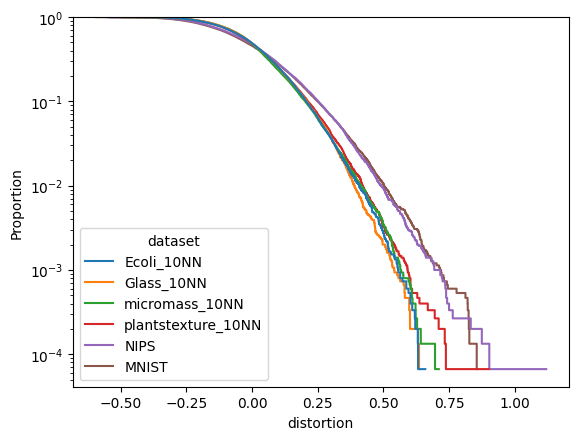

In [190]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

sns.ecdfplot(data=df[df['density']==1.0], x='distortion', hue='dataset', palette="tab10", complementary=True, log_scale=(False,True), ax=ax)

fig.savefig('comparison.svg')

<Axes: xlabel='distortion', ylabel='Proportion'>

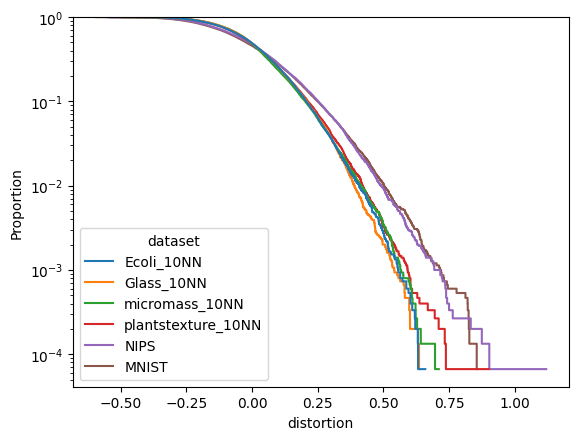

In [197]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

# mask = df['dataset'].isin(['Glass_10NN','NIPS'])
sns.ecdfplot(data=df, x='distortion', hue='dataset', palette="tab10", complementary=True, log_scale=(False,True), ax=ax)

<Axes: xlabel='distortion', ylabel='Density'>

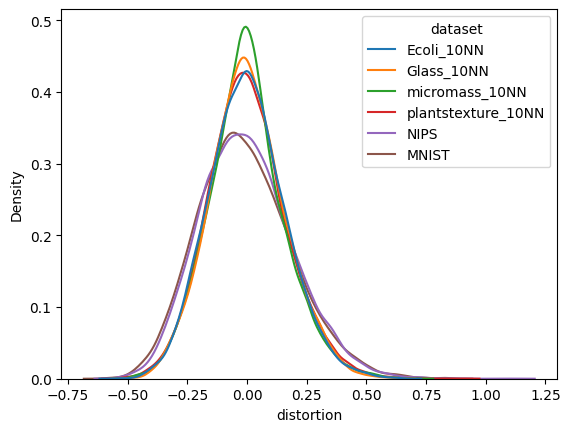

In [191]:
sns.kdeplot(data=df, x="distortion", hue="dataset",palette="tab10")

# Toy datasets, intro plot

In [35]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import random_projection
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 50000 # length of projection input
N_EMBED = 50 # length of projection output
L = [10,50,100] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing

outs = []
for l in L:
  # build vectors with L non-zero components out of N_INPUT

  X = np.zeros((N_INPUT,))

  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)

  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0)

  for dens in [0.1,0.5,1.0]:
    for _ in range(N_SAMPLES):
      transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
      X_new = transformer.fit_transform(X)
      distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
      #outs.append((distortion))
      outs.append((distortion,dens,'non_zero='+str(l)))

  #df = pd.DataFrame(outs, columns=["distortion", "density"])

  #sns.kdeplot(outs, legend=True)
  #sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")
df = pd.DataFrame(outs, columns=["distortion", "density", "non_zero"])


KeyboardInterrupt: 

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import random_projection
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 1000 # length of projection input
N_EMBED = 10 # length of projection output
L = [10] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing

dens_grid = [0.1,0.25,1.0]

np.random.seed(1234)

outs = []
outs1 = []
value1 = []
value2 = []
value3 = []
final = []

for l in L:
  # build vectors with L non-zero components out of N_INPUT
  X = np.zeros((N_INPUT,))

  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)

  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0)

  for dens in dens_grid:
    for i in range(N_SAMPLES):
      transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
      X_new = transformer.fit_transform(X)
      distortion = np.linalg.norm(X_new,2)**2-1 # squared distortion is bit smoother

      if dens == 0.1:
        value1.append(distortion)
      if dens == 0.25:
        value2.append(distortion)
      if dens == 1.0:
        value3.append(distortion)

      outs.append((distortion,dens))
      outs1.append((distortion,dens))

for i in range(N_SAMPLES):
  final.append((value1[i],value2[i],value3[i]))

df = pd.DataFrame(outs, columns=["distortion", "density"])
sns.ecdfplot(data=df, x="distortion", hue="density", palette="tab10",complementary=True, log_scale=(False,True))

df = pd.DataFrame(final, columns=["distortion","distortion","distortion"])
df.to_csv('intro_plot2.csv', sep=',')


In [ ]:
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
#fig,ax = plt.subplots()

xspace = np.linspace(-1,2.1,100)
ecdfs = [ECDF(df[df['density']==dens]['distortion'])(xspace) for dens in dens_grid]
ecdfs = pd.DataFrame(1-np.vstack(ecdfs).T,columns=dens_grid)
ecdfs['x'] = xspace
ecdfs.to_csv('ecdfs.csv')

#pd.DataFrame(ecdfs))
#np.vstack(ecdfs).T

#for dens in dens_grid:
#  ecdf = ECDF(df[df['density']==dens]['distortion'])
#  sns.lineplot(x=xspace,y=1-ecdf(xspace),ax=ax)
#ax.set(yscale='log')

In [ ]:
ecdfs

## More Examples